In [ ]:
#if zip file stored in drive
#!unzip -q "/content/drive/archive.zip"

unzip:  cannot find or open /content/drive/MyDrive/DATA/archive.zip, /content/drive/MyDrive/DATA/archive.zip.zip or /content/drive/MyDrive/DATA/archive.zip.ZIP.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/DATA/creditcard.csv")

___
Exploring the data
___

In [3]:
def view(data):
    shape=df.shape
    print('The shape of the dataframe(Rows X Columns) is :',shape)
    count = df['Class'].value_counts()  
    print("Count of samples in each class:\n",count)

In [4]:
view(df)

The shape of the dataframe(Rows X Columns) is : (284807, 31)
Count of samples in each class:
 0    284315
1       492
Name: Class, dtype: int64


In [5]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000
mean,94813.85958,0.00000,0.00000,-0.00000,0.00000,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,-0.00000,88.34962,0.00173
std,47488.14595,1.95870,1.65131,1.51626,1.41587,1.38025,1.33227,1.23709,1.19435,1.09863,1.08885,1.02071,0.99920,0.99527,0.95860,0.91532,0.87625,0.84934,0.83818,0.81404,0.77093,0.73452,0.72570,0.62446,0.60565,0.52128,0.48223,0.40363,0.33008,250.12011,0.04153
min,0.00000,-56.40751,-72.71573,-48.32559,-5.68317,-113.74331,-26.16051,-43.55724,-73.21672,-13.43407,-24.58826,-4.79747,-18.68371,-5.79188,-19.21433,-4.49894,-14.12985,-25.16280,-9.49875,-7.21353,-54.49772,-34.83038,-10.93314,-44.80774,-2.83663,-10.29540,-2.60455,-22.56568,-15.43008,0.00000,0.00000
25%,54201.50000,-0.92037,-0.59855,-0.89036,-0.84864,-0.69160,-0.76830,-0.55408,-0.20863,-0.64310,-0.53543,-0.76249,-0.40557,-0.64854,-0.42557,-0.58288,-0.46804,-0.48375,-0.49885,-0.45630,-0.21172,-0.22839,-0.54235,-0.16185,-0.35459,-0.31715,-0.32698,-0.07084,-0.05296,5.60000,0.00000
50%,84692.00000,0.01811,0.06549,0.17985,-0.01985,-0.05434,-0.27419,0.04010,0.02236,-0.05143,-0.09292,-0.03276,0.14003,-0.01357,0.05060,0.04807,0.06641,-0.06568,-0.00364,0.00373,-0.06248,-0.02945,0.00678,-0.01119,0.04098,0.01659,-0.05214,0.00134,0.01124,22.00000,0.00000
75%,139320.50000,1.31564,0.80372,1.02720,0.74334,0.61193,0.39856,0.57044,0.32735,0.59714,0.45392,0.73959,0.61824,0.66250,0.49315,0.64882,0.52330,0.39967,0.50081,0.45895,0.13304,0.18638,0.52855,0.14764,0.43953,0.35072,0.24095,0.09105,0.07828,77.16500,0.00000
max,172792.00000,2.45493,22.05773,9.38256,16.87534,34.80167,73.30163,120.58949,20.00721,15.59499,23.74514,12.01891,7.84839,7.12688,10.52677,8.87774,17.31511,9.25353,5.04107,5.59197,39.42090,27.20284,10.50309,22.52841,4.58455,7.51959,3.51735,31.61220,33.84781,25691.16000,1.00000


####Data distribution among both non-fraud and fraud classes

In [6]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


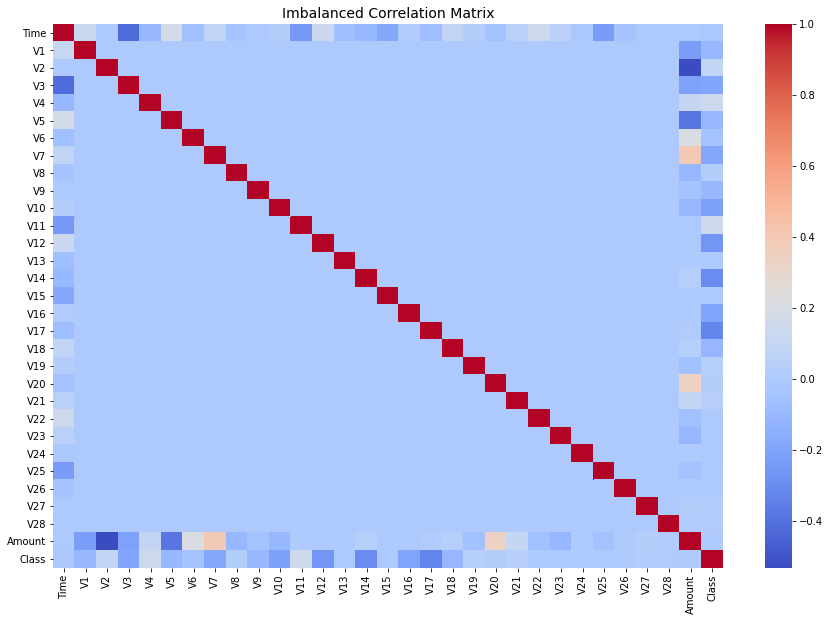

In [7]:
fig, ax = plt.subplots(figsize=(15,10)) 
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, '(0: No Fraud || 1: Fraud)')

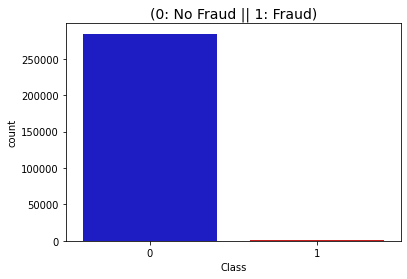

In [8]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('(0: No Fraud || 1: Fraud)', fontsize=14)

####Exploring the Time feature

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


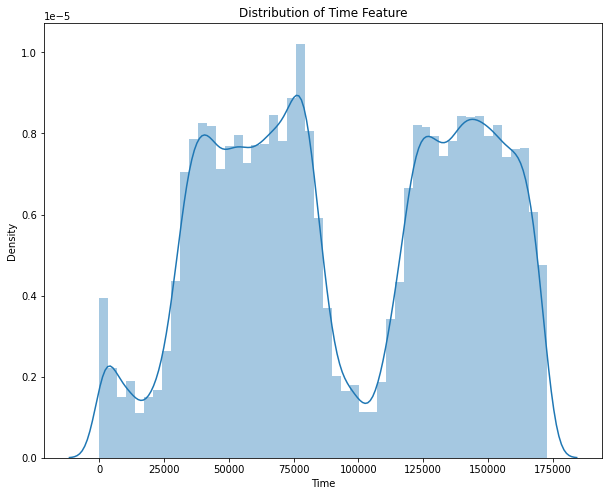

In [9]:
plt.figure(figsize=(10,8))
plt.title('Distribution of Time Feature')
sns.distplot(df.Time)

###Since Amount and Time are having higher values from other features we have to scale them according to our given features and also Time feature is not important because it is of small duration

In [10]:
df['Scaled_Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df = df.drop(['Time', 'Amount'], axis=1)

In [11]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Scaled_Amount
0,-1.35981,-0.07278,2.53635,1.37816,-0.33832,0.46239,0.23960,0.09870,0.36379,0.09079,-0.55160,-0.61780,-0.99139,-0.31117,1.46818,-0.47040,0.20797,0.02579,0.40399,0.25141,-0.01831,0.27784,-0.11047,0.06693,0.12854,-0.18911,0.13356,-0.02105,0,0.24496
1,1.19186,0.26615,0.16648,0.44815,0.06002,-0.08236,-0.07880,0.08510,-0.25543,-0.16697,1.61273,1.06524,0.48910,-0.14377,0.63556,0.46392,-0.11480,-0.18336,-0.14578,-0.06908,-0.22578,-0.63867,0.10129,-0.33985,0.16717,0.12589,-0.00898,0.01472,0,-0.34247
2,-1.35835,-1.34016,1.77321,0.37978,-0.50320,1.80050,0.79146,0.24768,-1.51465,0.20764,0.62450,0.06608,0.71729,-0.16595,2.34586,-2.89008,1.10997,-0.12136,-2.26186,0.52498,0.24800,0.77168,0.90941,-0.68928,-0.32764,-0.13910,-0.05535,-0.05975,0,1.16069
3,-0.96627,-0.18523,1.79299,-0.86329,-0.01031,1.24720,0.23761,0.37744,-1.38702,-0.05495,-0.22649,0.17823,0.50776,-0.28792,-0.63142,-1.05965,-0.68409,1.96578,-1.23262,-0.20804,-0.10830,0.00527,-0.19032,-1.17558,0.64738,-0.22193,0.06272,0.06146,0,0.14053
4,-1.15823,0.87774,1.54872,0.40303,-0.40719,0.09592,0.59294,-0.27053,0.81774,0.75307,-0.82284,0.53820,1.34585,-1.11967,0.17512,-0.45145,-0.23703,-0.03819,0.80349,0.40854,-0.00943,0.79828,-0.13746,0.14127,-0.20601,0.50229,0.21942,0.21515,0,-0.07340


In [12]:
#function for plotting confusion matrix
def plot_cm(cm):
  plt.figure(figsize = (15,3))
  plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
  plt.subplot(1,2,1)
  sns.heatmap(cm, annot = True, fmt = 'g', cmap = plt.cm.Blues)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title("Recall Score: {}%".format(100*cm[1,1]/(cm[1,0]+cm[1,1])))
  plt.show()

#K-Fold Cross validation
###Finding the best parameters

In [13]:
#function for Kfold and Grid search
def Grid_Kfold(X_data,y_data):
  model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = {"C": [0.01, 0.1, 1, 10, 100]}, 
                        scoring= 'roc_auc', 
                        cv = KFold(n_splits=10, shuffle=True, random_state=42), 
                        n_jobs=3,
                        verbose = 5,
                        return_train_score=True)
  model_cv.fit(X_data,y_data)
  print('Best ROC AUC score: ', model_cv.best_score_)
  #print the optimum value of hyperparameters
  print('Best hyperparameters: ', model_cv.best_params_)

#Logistic Regression(L1) using Downsampling

In [14]:
X = df.iloc[:, df.columns != 'Class']
y = df.iloc[:, df.columns == 'Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [15]:
fraud_sample = len(df[df.Class == 1])

#getting index of fraud transactions
fraud_indices = np.array(df[df.Class == 1].index)
#getting index of normal transactions
normal_indices = df[df.Class == 0].index
#extract random samples to create sub-smaples 
random_normal_indices = np.random.choice(normal_indices, fraud_sample, replace=False)
random_normal_indices = np.array(random_normal_indices)

#combine both the samples,Total 984 samples
us_indices = np.concatenate([fraud_indices, random_normal_indices])

#creating sub-samples
u_data = df.iloc[us_indices, :]
X_undersample = u_data.iloc[:, u_data.columns != 'Class']
y_undersample = u_data.iloc[:, u_data.columns == 'Class']

#splitting the under sampled data
X_train_undersample,X_test_undersample,y_train_undersample,y_test_undersample = train_test_split(X_undersample,y_undersample,test_size = 0.3,random_state = 0)

In [16]:
Grid_Kfold(X_undersample,y_undersample)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    2.1s


Best ROC AUC score:  0.9799775240608861
Best hyperparameters:  {'C': 0.01}


[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    3.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


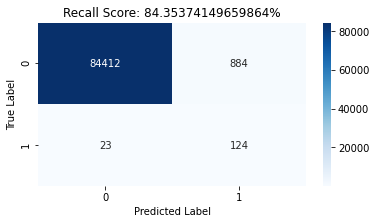

In [17]:
lr = LogisticRegression(C = 0.01, penalty = 'l1',solver='saga')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test.values)
cnf_matrix_undersample = confusion_matrix(y_test, y_pred_undersample) 
#calling function
plot_cm(cnf_matrix_undersample)

#Logistic Regression(L2) using Oversampling(SMOTE)

In [18]:
#creating two variables
columns=df.columns
#sepersting features without the traget variable
features_columns=columns.delete(len(columns)-1)
features=df[features_columns]
#seperating the target class
labels=df['Class']

train_features, test_features, train_labels, test_labels = train_test_split(features,labels, test_size=0.3, random_state=0)
#using SMOTE
oversample=SMOTE(random_state=0)
os_features,os_labels=oversample.fit_sample(train_features,train_labels)

os_features = pd.DataFrame(os_features)
os_labels = pd.DataFrame(os_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [19]:
Grid_Kfold(os_features,os_labels)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   28.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  2.8min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best ROC AUC score:  1.0
Best hyperparameters:  {'C': 0.1}


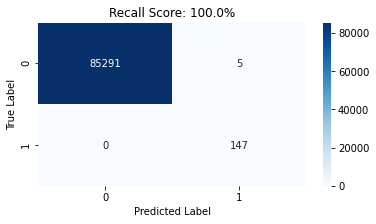

In [20]:
#training with best C score
lr1 = LogisticRegression(C = 0.1, penalty = 'l2')
lr1.fit(os_features,os_labels.values.ravel())
y_pred = lr1.predict(test_features.values)

cnf_matrix = confusion_matrix(test_labels, y_pred) 
plot_cm(cnf_matrix)



##Training with Feature Selection

In [21]:
sel_ = SelectFromModel(LogisticRegression(C=0.1, penalty='l1',solver='saga'))
sel_.fit(os_features,os_labels.values.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


SelectFromModel(estimator=LogisticRegression(C=0.1, class_weight=None,
                                             dual=False, fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='auto',
                                             n_jobs=None, penalty='l1',
                                             random_state=None, solver='saga',
                                             tol=0.0001, verbose=0,
                                             warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [22]:
sf = sel_.get_support()
print(sf)

[ True  True False  True  True  True  True  True False  True  True  True
  True  True False  True  True False False False  True  True  True False
 False False False False  True]


In [23]:
print('total features: {}'.format((os_features.shape[1])))
print('selected features: {}'.format(sf.sum()))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))
a = np.sum(sel_.estimator_.coef_ == 0)
print('The number of features which can be removed :',a)
X_train_selected = sel_.transform(os_features)

total features: 29
selected features: 18
features with coefficients shrank to zero: 9
The number of features which can be removed : 9


###Training with selected features

In [24]:
lr_l2 = LogisticRegression(C=0.1,penalty='l1',solver='saga')
lr_l2.fit(X_train_selected,os_labels.values.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
from sklearn.metrics import (f1_score, roc_auc_score,confusion_matrix, accuracy_score,
                             precision_score, recall_score)
from IPython.display import HTML, display
import tabulate
def predict_and_evaluate(model, x_test, y_test):
    predictions = model.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    
    metrics = [round(accuracy,2),fp, fn, round(precision,2), round(recall,2), round(f1,2)]
    table = [[model.__class__.__name__] + metrics]
    display(HTML(tabulate.tabulate(table,headers=('Algorithm','accuracy','False Positives', 
                                                  'False Negatives', 'Precision', 
                                                  'Recall', 'F1 Score'), 
                                   tablefmt='html')))
    #print(accuracy)
    return [model.__class__.__name__] + metrics

In [26]:
lr_res = predict_and_evaluate(lr,X_test,y_test)
l1_res = predict_and_evaluate(lr1,X_test,y_test)

Algorithm,accuracy,False Positives,False Negatives,Precision,Recall,F1 Score
LogisticRegression,0.93,0,22,1,0.85,0.92


Algorithm,accuracy,False Positives,False Negatives,Precision,Recall,F1 Score
LogisticRegression,1,5,0,0.97,1,0.98
